In [2]:
from urllib.parse import urljoin, urlsplit
import requests
from bs4 import BeautifulSoup
from tqdm import tqdm
import time

def scrape_urls(url, pages, urlfilename):
    # Part 1: Scrape URLs
    master_urls = []  # Create an empty list to store the URLs
    base_url = f"{urlsplit(url).scheme}://{urlsplit(url).netloc}"

    for i in tqdm(range(1, pages + 1), desc="Scraping URLs"):
        # Construct the URL for the current page
        page_url = f"{url}?PG={i}"
        
        try:
            # Make a GET request to the page
            result = requests.get(page_url)
            result.raise_for_status()  # Check for request errors
            
            # Parse the HTML content of the page
            soup = BeautifulSoup(result.text, 'html.parser')

            # Find and extract the URLs of master's degree courses
            course_links = soup.find_all('a', class_='courseLink text-dark')
            for link in course_links:
                course_url = urljoin(base_url, link.get('href'))
                master_urls.append(course_url)

            # Introduce a delay to avoid overloading the website
            time.sleep(1)
        except requests.RequestException as e:
            print(f"Error processing page {i}: {e}")
            continue  # Skip to the next iteration if there's an error

    # Save the URLs to a text file
    with open(urlfilename, 'w') as file:
        for url in master_urls:
            file.write(url + '\n')

    print(f'\nThe URLs are now saved in the file {urlfilename}')

This Python script is a web scraper designed to collect URLs of master's degree courses from a website. Here's a breakdown of its functionality:

1. **Importing Libraries:**
   - `urljoin` and `urlsplit` from `urllib.parse`: Used for URL manipulation.
   - `requests`: Enables making HTTP requests.
   - `BeautifulSoup`: A library for HTML parsing.
   - `tqdm`: Provides a progress bar for the scraping process.
   - `time`: Used to introduce a delay between requests.

2. **Function - `scrape_urls(url, pages, urlfilename):`**
   - Takes three parameters: `url` (base URL), `pages` (number of pages to scrape), and `urlfilename` (name of the file to save URLs).
   - Initializes an empty list, `master_urls`, to store the extracted URLs.
   - Constructs the base URL using `urlsplit`.
   - Iterates through the specified number of pages.
   - Constructs the URL for each page and makes a GET request.
   - Parses the HTML content using BeautifulSoup.
   - Extracts URLs of master's degree courses from the HTML.
   - Appends the extracted URLs to the `master_urls` list.
   - Introduces a 1-second delay between requests to avoid overloading the website.
   - If a request encounters an error, it prints an error message and continues to the next iteration.
   - After scraping all pages, the extracted URLs are saved to a text file specified by `urlfilename`.
   - Prints a message indicating the successful completion of the URL extraction and saving process.

In [2]:
scrape_urls("https://www.findamasters.com/masters-degrees/msc-degrees/", 400, "master_urls.txt")

Scraping URLs: 100%|██████████████████████████| 400/400 [14:39<00:00,  2.20s/it]


The URLs are now saved in the file master_urls.txt


In [3]:
import os
import requests
from tqdm import tqdm
import time
import random

def scrape_htmls(urlfilename, htmlfolderName):
    # Part 2: Scrape HTML
    # Read the lines of the file with the URLs
    with open(urlfilename, 'r') as archive:
        urls = archive.readlines()

    output_folder = htmlfolderName
    # Create an output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)

    for i, url in tqdm(enumerate(urls, start=1), desc="Scraping HTMLs"):
        # Remove '\n' from the URL
        link = url.strip()

        # Retry logic for 429 errors
        max_retries = 3
        for attempt in range(max_retries):
            try:
                # Get the HTML content
                html = requests.get(link)
                html.raise_for_status()

                # Create the output file path in the output folder
                output_file = os.path.join(output_folder, f'Html-{i}.txt')

                # Write the HTML content to the file
                with open(output_file, 'a') as doc:
                    doc.write(html.text)

                # Pause for a short duration to be respectful to the server
                time.sleep(1.5 + random.uniform(0, 2))
                
                break  # Break out of the retry loop if successful

            except requests.RequestException as e:
                if attempt < max_retries - 1 and e.response.status_code == 429:
                    print(f"Received 429 error. Retrying in 10 seconds. Attempt {attempt + 1}/{max_retries}")
                    time.sleep(10)
                else:
                    print(f"Error processing URL {link}: {e}")
                    # Continue with the next URL even if an error occurs
                    break


This Python script is a continuation of the web scraping process. It focuses on downloading and saving the HTML content of the URLs previously extracted using the `scrape_urls` function. Here's an explanation of the code:

1. **Importing Libraries:**
   - `os`: Provides a way to interact with the operating system, used for creating directories.
   - `requests`: Used for making HTTP requests to fetch HTML content.
   - `tqdm`: Provides a progress bar for the scraping process.
   - `time`: Used for introducing delays between requests.
   - `random`: Used for generating random values, adding variability to the pause duration.

2. **Function - `scrape_htmls(urlfilename, htmlfolderName):`**
   - Takes two parameters: `urlfilename` (name of the file containing URLs) and `htmlfolderName` (name of the folder to save HTML files).
   - Reads the URLs from the file specified by `urlfilename`.
   - Creates an output folder specified by `htmlfolderName` if it doesn't exist.
   - Iterates through each URL.
   - Strips the newline character from the URL.
   - Implements a retry mechanism for HTTP 429 errors (rate limiting) with a maximum of 3 attempts.
   - Downloads the HTML content using the `requests.get` method.
   - Saves the HTML content to a text file within the output folder.
   - Introduces a delay between requests to be considerate to the server, with a random component for variability.
   - Prints a message if a 429 error is encountered, indicating a retry after a 10-second pause.
   - If an error other than a 429 status code occurs, prints an error message and continues to the next URL.


In [3]:
scrape_htmls("master_urls.txt", "html_masters")

Scraping HTMLs: 6000it [5:15:14,  3.15s/it]


In [1]:
import os
import csv
from bs4 import BeautifulSoup
from tqdm import tqdm

def extract_course_info(html_folder, output_folder, urls_file):
    # Create the output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Read the URLs from the URLs file
    with open(urls_file, 'r', encoding='utf-8') as urls_file:
        urls = urls_file.read().splitlines()

    # Define column names
    column_names = [
        "courseName", "universityName", "facultyName", "isItFullTime", "description",
        "startDate", "fees", "modality", "duration", "city", "country", "administration", "url"
    ]

    # Iterate through each HTML file with tqdm progress bar
    for i, url in enumerate(tqdm(urls, desc="Processing HTML files", unit="file"), start=1):
        html_filename = os.path.join(html_folder, f'Html-{i}.txt')
        output_filename = os.path.join(output_folder, f'course_{i}.tsv')

        # Initialize variables to store extracted data
        extracted_data = {name: "" for name in column_names}

        with open(html_filename, 'r', encoding='utf-8') as html_file:
            html_content = html_file.read()
            soup = BeautifulSoup(html_content, 'html.parser')

            # Extract data using a dictionary
            extracted_data["courseName"] = soup.find('h1', class_='text-white course-header__course-title')
            if extracted_data["courseName"]:
                extracted_data["courseName"] = extracted_data["courseName"].get_text(strip=True)

            inst_dept_element = soup.find('h3', class_='h5 course-header__inst-dept')
            if inst_dept_element:
                institution_element = inst_dept_element.find('a', class_='course-header__institution')
                department_element = inst_dept_element.find('a', class_='course-header__department')

                extracted_data["universityName"] = institution_element.get_text(strip=True) if institution_element else ""
                extracted_data["facultyName"] = department_element.get_text(strip=True) if department_element else ""

            key_info_elements = soup.find('div', class_='key-info__outer')
            if key_info_elements:
                extracted_data["isItFullTime"] = key_info_elements.find('span', class_='key-info__study-type').get_text(strip=True) if key_info_elements.find('span', class_='key-info__study-type') else ""
                extracted_data["startDate"] = key_info_elements.find('span', class_='key-info__start-date').get_text(strip=True) if key_info_elements.find('span', class_='key-info__start-date') else ""
                extracted_data["modality"] = key_info_elements.find('span', class_='key-info__qualification').get_text(strip=True) if key_info_elements.find('span', class_='key-info__qualification') else ""
                extracted_data["duration"] = key_info_elements.find('span', class_='key-info__duration').get_text(strip=True) if key_info_elements.find('span', class_='key-info__duration') else ""

            course_data_element = soup.find('div', class_='course-data__container col-24 ml-md-n1 p-0 pb-3')
            if course_data_element:
                extracted_data["city"] = course_data_element.find('a', class_='course-data__city').get_text(strip=True) if course_data_element.find('a', class_='course-data__city') else ""
                extracted_data["country"] = course_data_element.find('a', class_='course-data__country').get_text(strip=True) if course_data_element.find('a', class_='course-data__country') else ""
                extracted_data["administration"] = course_data_element.find('a', class_='course-data__on-campus').get_text(strip=True) if course_data_element.find('a', class_='course-data__on-campus') else ""

            fees_element = soup.find('div', class_='course-sections__fees')
            fees_paragraph = fees_element.find('p') if fees_element else None
            if fees_paragraph and "Please see the university website for further information on fees for this course." not in fees_paragraph.get_text(strip=True):
                extracted_data["fees"] = fees_paragraph.get_text(strip=True)

            description_element = soup.find('div', class_='course-sections__description')
            description_paragraph = description_element.find('p') if description_element else None
            extracted_data["description"] = description_paragraph.get_text(strip=True) if description_paragraph else ""

        # Extract and save the URL
            extracted_data["url"] = url

            # Write the extracted data to a TSV file using csv.writer
            with open(output_filename, 'w', encoding='utf-8', newline='') as output_file:
                writer = csv.writer(output_file, delimiter='\t')
                writer.writerow(column_names)  # Write the header row
                writer.writerow([extracted_data[name] for name in column_names])


This Python script is responsible for extracting specific information from HTML files (previously scraped web pages) related to master's degree courses. The extracted data is then organized and saved into TSV (Tab-Separated Values) files. Here's an explanation of the code:

1. **Importing Libraries:**
   - `os`: Provides functions for interacting with the operating system, used for creating directories.
   - `csv`: Allows reading and writing CSV files.
   - `BeautifulSoup`: A library for HTML parsing.
   - `tqdm`: Provides a progress bar for the extraction process.

2. **Function - `extract_course_info(html_folder, output_folder, urls_file):`**
   - Takes three parameters: `html_folder` (folder containing HTML files), `output_folder` (folder to save extracted information), and `urls_file` (file containing URLs).
   - Creates the output folder if it doesn't exist.
   - Reads the URLs from the file specified by `urls_file`.
   - Defines column names for the extracted information.
   - Iterates through each HTML file with a tqdm progress bar.
   - Initializes a dictionary, `extracted_data`, to store the extracted information for each course.
   - Parses each HTML file using BeautifulSoup.
   - Extracts course information such as name, university, faculty, study type, start date, modality, duration, city, country, administration, fees, description, and URL.
   - Saves the extracted information into a TSV file using `csv.writer`.
   - The header row includes column names, and subsequent rows contain the corresponding data.
   - The entire process is repeated for each HTML file, and progress is displayed with the tqdm progress bar.

In [2]:
extract_course_info("html_masters", "masters_tsv ", "master_urls.txt")

Processing HTML files: 100%|██████████████| 6000/6000 [02:52<00:00, 34.85file/s]


In [3]:
import os
import pandas as pd

def create_dataframe(column_names, folder_name, num_files):
    # Initialize an empty list to store DataFrames
    dfs = []

    # Define the folder path where TSV files are located
    folder_path = folder_name

    # Iterate through each TSV file and append its data to the list of DataFrames
    for i in range(1, num_files + 1):
        file_name = f'course_{i}.tsv'
        file_path = os.path.join(folder_path, file_name)

        # Check if the file exists before trying to load it
        if os.path.exists(file_path):
            with open(file_path, 'r') as file:
                # Skip the first row (header)
                next(file)

                # Read the second row (data)
                data_row = file.readline()

                # Extract values from the row and create a dictionary
                data_dict = dict(zip(column_names, data_row.strip().split('\t')))

                # Convert the dictionary to a DataFrame and append it to the list
                df = pd.DataFrame([data_dict])
                dfs.append(df)

    # Concatenate the list of DataFrames into a single DataFrame
    all_courses = pd.concat(dfs, ignore_index=True)

    return all_courses

This Python script is designed to read multiple TSV (Tab-Separated Values) files containing course information, create individual DataFrames for each file, and then concatenate these DataFrames into a single, comprehensive DataFrame. The resulting DataFrame can be used for further analysis and manipulation. Here's an explanation of the code:

1. **Importing Libraries:**
   - `os`: Provides functions for interacting with the operating system, used for working with file paths and checking file existence.
   - `pandas` (`pd`): A powerful data manipulation library that provides data structures like DataFrames.

2. **Function - `create_dataframe(column_names, folder_name, num_files):`**
   - Takes three parameters: `column_names` (list of column names for the DataFrame), `folder_name` (folder containing TSV files), and `num_files` (the number of TSV files to process).
   - Initializes an empty list, `dfs`, to store individual DataFrames.
   - Defines the folder path where TSV files are located.
   - Iterates through each TSV file, reads the data, and creates a DataFrame for each file.
   - Checks if the file exists before attempting to load it.
   - Skips the header row and reads the second row (data) from each TSV file.
   - Converts the row data into a dictionary, where keys are column names and values are corresponding data.
   - Converts the dictionary into a DataFrame and appends it to the list of DataFrames (`dfs`).
   - Concatenates all DataFrames in the list into a single DataFrame (`all_courses`).
   - Returns the resulting DataFrame containing information from all the TSV files.

This function essentially consolidates course information from multiple files into a single DataFrame, making it easier to analyze and manipulate the data as a whole.

In [4]:
column_names = ["courseName","universityName", "facultyName", "isItFullTime", "description", "startDate", "fees", "modality",
                "duration","city","country","administration","url"]
courses = create_dataframe(column_names, "masters_tsv ", 6000)

In [5]:
courses.head()

,courseName,universityName,facultyName,isItFullTime,description,startDate,fees,modality,duration,city,country,administration,url
0,Accounting and Finance (MSc),University of Bath,School of Management,Full time,Develop in-depth knowledge of accounting and f...,September,,MSc,1 year full-time,Bath,United Kingdom,On Campus,https://www.findamasters.com/masters-degrees/c...
1,"Accounting, Accountability & Financial Managem...",King’s College London,King’s Business School,Full time,"Our Accounting, Accountability & Financial Man...",September,,MSc,1 year FT,London,United Kingdom,On Campus,https://www.findamasters.com/masters-degrees/c...
2,"Accounting, Financial Management and Digital B...",University of Reading,Henley Business School,Full time,Embark on a professional accounting career wit...,September,,MSc,1 year full time,Reading,United Kingdom,On Campus,https://www.findamasters.com/masters-degrees/c...
3,Addictions MSc,King’s College London,"Institute of Psychiatry, Psychology and Neuros...",Full time&Part time,Join us for an online session for prospective ...,September,,MSc,One year FT,London,United Kingdom,On Campus,https://www.findamasters.com/masters-degrees/c...
4,Advanced Chemical Engineering - MSc,University of Leeds,School of Chemical and Process Engineering,Full time,The Advanced Chemical Engineering MSc at Leeds...,September,"UK: £13,750 (Total)International: £31,000 (Total)",MSc,1 year full time,Leeds,United Kingdom,On Campus,https://www.findamasters.com/masters-degrees/c...


In [6]:
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

def preprocess_msc(text):
    # Ensure the text is a string by converting to string
    text = str(text)
    
    # Lowercasing the text
    text = text.lower()
    
    # Tokenization (splitting text into words)
    words = word_tokenize(text)
    
    # Removing punctuation and special characters
    table = str.maketrans('', '', string.punctuation)
    words = [word.translate(table) for word in words]
    
    # Removing stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    
    # Stemming using Porter stemmer
    stemmer = PorterStemmer()
    words = [stemmer.stem(word) for word in words]
    
    # Joining the processed words back into a single string
    processed_msc = ' '.join(words)
    
    return processed_msc

In [7]:
courses['Processed_description'] = courses['description'].apply(preprocess_msc)

In [8]:
print(courses['Processed_description'].head())

0    develop indepth knowledg account financ theori...
1    account  account  financi manag msc cours prov...
2      embark profession account career academ ground 
3    join us onlin session prospect student find ms...
4    advanc chemic engin msc leed build core founda...
Name: Processed_description, dtype: object


In [9]:
import re

def extract_max_fee(row):
    # Convert row to string to handle with regex
    row_str = str(row)

    # Regex to extract fees in different currencies from the dataframe
    fees_matches = re.findall(r'((?:(?:\d[\d,]*)\s?(?:[£$€]|(?:EUR|CHF|ISK|HK\$|RMB|CZK|SEK|HKD|SGD\s\$|JPY|QR)))|(?:(?:[£$€]|(?:EUR|CHF|ISK|HK\$|RMB|CZK|SEK|HKD|SGD\s\$|JPY|QR))\s?(?:\d[\d,.]*)))', row_str)

    # Return None if no fees found
    if not fees_matches:
        return None, None

    # Lists to store values and currencies
    values = []
    currencies = []

    # Iterate through the matches and extract values and currencies
    for fee_match in fees_matches:
        currency_match = re.search(r'(?:[£$€]|(?:EUR|CHF|ISK|HK\$|RMB|CZK|SEK|HKD|SGD\s\$|JPY|QR))', fee_match)
        value_match = re.search(r'(?:\d[\d,]*)', fee_match)

        # Check if both currency and value are found
        if currency_match and value_match:
            currency = currency_match.group()
            value_str = value_match.group()

            # Handling Euro and ISK currencies
            if currency in {'€', 'ISK'}:
                value = float(value_str.replace('.', '').replace(',', ''))
            else:
                value = float(value_str.replace(',', ''))

            values.append(value)
            currencies.append(currency)

    if values:
        # Consider only the maximum fee value in the cell
        max_value = max(values)
        max_currency = currencies[values.index(max_value)]
        return max_value, max_currency
    else:
        return None, None

In [10]:
courses[['fees', 'currency']] = courses['fees'].apply(extract_max_fee).apply(pd.Series)
courses[courses['fees'].notna()][['fees','currency']].head(5)

,fees,currency
4,31000.0,£
5,177600.0,SEK
6,9000.0,€
7,28750.0,£
11,9000.0,€


In [11]:
import pandas as pd

# Specify the file path for the TSV file
tsv_file = 'courses_tsv.tsv'

# Save the DataFrame to a TSV file
courses.to_csv(tsv_file, sep='\t', index=False)

# Optionally, you can print a message to confirm the operation
print(f"The DataFrame has been successfully exported to {tsv_file}")

The DataFrame has been successfully exported to courses_tsv.tsv


In [12]:
courses1=pd.read_csv('courses_tsv.tsv',sep='\t')

In [13]:
courses1.head()

,courseName,universityName,facultyName,isItFullTime,description,startDate,fees,modality,duration,city,country,administration,url,Processed_description,currency
0,Accounting and Finance (MSc),University of Bath,School of Management,Full time,Develop in-depth knowledge of accounting and f...,September,NaN,MSc,1 year full-time,Bath,United Kingdom,On Campus,https://www.findamasters.com/masters-degrees/c...,develop indepth knowledg account financ theori...,NaN
1,"Accounting, Accountability & Financial Managem...",King’s College London,King’s Business School,Full time,"Our Accounting, Accountability & Financial Man...",September,NaN,MSc,1 year FT,London,United Kingdom,On Campus,https://www.findamasters.com/masters-degrees/c...,account account financi manag msc cours prov...,NaN
2,"Accounting, Financial Management and Digital B...",University of Reading,Henley Business School,Full time,Embark on a professional accounting career wit...,September,NaN,MSc,1 year full time,Reading,United Kingdom,On Campus,https://www.findamasters.com/masters-degrees/c...,embark profession account career academ ground,NaN
3,Addictions MSc,King’s College London,"Institute of Psychiatry, Psychology and Neuros...",Full time&Part time,Join us for an online session for prospective ...,September,NaN,MSc,One year FT,London,United Kingdom,On Campus,https://www.findamasters.com/masters-degrees/c...,join us onlin session prospect student find ms...,NaN
4,Advanced Chemical Engineering - MSc,University of Leeds,School of Chemical and Process Engineering,Full time,The Advanced Chemical Engineering MSc at Leeds...,September,31000.0,MSc,1 year full time,Leeds,United Kingdom,On Campus,https://www.findamasters.com/masters-degrees/c...,advanc chemic engin msc leed build core founda...,£


In [14]:
import json
from collections import defaultdict

# Step 1: Collect Unique Terms and Build Vocabulary
terms = set()

# Iterate through the DataFrame to collect unique terms
for index, row in courses1.iterrows():
    stemmed_words = row["Processed_description"].split()
    terms.update(stemmed_words)

# Sort the unique terms
terms = sorted(terms)

# Create a vocabulary by assigning term_ids to unique terms
vocabulary = {term: idx for idx, term in enumerate(terms, start=1)}

# Save the sorted vocabulary to a text file
vocabulary_file_path = "vocabulary.txt"
with open(vocabulary_file_path, "w") as vocab_file:
    for term, term_id in vocabulary.items():
        vocab_file.write(f"{term} {term_id}\n")
print(f"Vocabulary saved to: {vocabulary_file_path}")

# Step 2: Build Inverted Index as a Dictionary
inverted_index = defaultdict(list)

# Iterate through the DataFrame to build the inverted index
for index, row in courses1.iterrows():
    document_id = index + 1  # Assuming document_id starts from 1
    stemmed_words = row["Processed_description"].split()

    # Consider only unique words in each document
    for word in set(stemmed_words):
        term_id = vocabulary.get(word)
        if term_id:
            inverted_index[term_id].append(document_id)

# Step 3: Save Inverted Index to a JSON file
inverted_index_file_path = "inverted_index.json"
with open(inverted_index_file_path, "w") as index_file:
    json.dump(inverted_index, index_file)
print(f"Inverted Index saved to: {inverted_index_file_path}")


Vocabulary saved to: vocabulary.txt
Inverted Index saved to: inverted_index.json


This Python script focuses on building a vocabulary and constructing an inverted index from the processed descriptions of courses stored in a DataFrame. The resulting vocabulary and inverted index are saved to separate files. Here's an explanation of the code:

1. **Importing Libraries:**
   - `json`: Allows encoding and decoding JSON data.
   - `collections.defaultdict`: Provides a dictionary with default values for new keys.

2. **Steps for Building Vocabulary and Inverted Index:**
   - **Step 1: Collect Unique Terms and Build Vocabulary**
      - Initializes an empty set, `terms`, to store unique terms.
      - Iterates through the rows of the DataFrame (`courses1`) and extracts processed descriptions.
      - Splits the processed descriptions into stemmed words and updates the set of unique terms (`terms`).
      - Sorts the unique terms alphabetically.
      - Creates a vocabulary by assigning term_ids to unique terms.
      - Saves the sorted vocabulary to a text file (`vocabulary.txt`).
  
   - **Step 2: Build Inverted Index as a Dictionary**
      - Initializes an empty defaultdict (`inverted_index`) to store the inverted index.
      - Iterates through the rows of the DataFrame.
      - Assigns a unique document_id to each row.
      - Splits the processed descriptions into stemmed words.
      - Considers only unique words in each document.
      - Maps each unique word to its corresponding term_id using the vocabulary.
      - Appends the document_id to the list associated with the term_id in the inverted index.
  
   - **Step 3: Save Inverted Index to a JSON File**
      - Saves the constructed inverted index to a JSON file (`inverted_index.json`).
      - The resulting JSON file contains term_ids as keys, and each key maps to a list of document_ids where the term appears.

3. **Final Output:**
   - Vocabulary is saved to `vocabulary.txt`.
   - Inverted Index is saved to `inverted_index.json`.

These files can be used for tasks like information retrieval and text analysis, allowing efficient querying and retrieval of documents containing specific terms.

In [15]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def process_query(query, courses_df, vectorizer=None):
    # Combine the query with the existing processed descriptions in the DataFrame
    query_text = " ".join(query.split())

    # If vectorizer is not provided, fit a new one on the entire description column
    if vectorizer is None:
        vectorizer = TfidfVectorizer().fit(courses_df["description"])

    # Transform the query using the vectorizer
    query_vector = vectorizer.transform([query_text])

    # Transform the documents using the same vectorizer
    document_vectors = vectorizer.transform(courses_df["description"])

    # Compute Cosine Similarity between the query vector and document vectors
    similarity_scores = cosine_similarity(query_vector, document_vectors).flatten()

    # Create a DataFrame to store the results
    results_df = pd.DataFrame({
        "courseName": courses_df["courseName"],
        "universityName": courses_df["universityName"],
        "description": courses_df["description"],
        "url":courses_df["url"],
        "similarity_score": similarity_scores
    })

    # Sort the DataFrame based on similarity scores in descending order
    results_df = results_df.sort_values(by="similarity_score", ascending=False)

    return results_df

# Sample query from the user
user_query = input("Enter your query: ")

# Call the function to process the query
results_df = process_query(user_query, courses1)

# Display only the top 10 rows of the results
pd.set_option('display.max_rows', 10)
results_df.head(10)[["courseName", "universityName", "description","url", "similarity_score"]]

Enter your query:  advanced knowledge


,courseName,universityName,description,url,similarity_score
3684,Food and Nutrition Sciences (MSc),Sheffield Hallam University,Gain advanced food industry knowledge and prac...,https://www.findamasters.com/masters-degrees/c...,0.432877
957,Advanced Software Engineering MSc,King’s College London,Our Advanced Software Engineering MSc is an ad...,https://www.findamasters.com/masters-degrees/c...,0.396424
3903,Global Biodiversity Conservation - MSc,University of Sussex,This MSc will give you advanced knowledge and ...,https://www.findamasters.com/masters-degrees/c...,0.384368
838,Advanced Healthcare Practice - MSc,Cardiff University,Our MSc Advanced Healthcare Practice programme...,https://www.findamasters.com/masters-degrees/c...,0.362080
875,Advanced Mechanical Engineering - MSc,Cardiff University,This degree programme aims to provide advanced...,https://www.findamasters.com/masters-degrees/c...,0.342867
809,Advanced Computing MSc,King’s College London,Our Advanced Computing MSc provides knowledge ...,https://www.findamasters.com/masters-degrees/c...,0.337868
806,Advanced Computing - MSc,University of the West of Scotland,Our MSc Advanced Computing course is designed ...,https://www.findamasters.com/masters-degrees/c...,0.325126
757,Advanced Clinical Practice MSc,University of Greenwich,Develop your skills and deepen your knowledge ...,https://www.findamasters.com/masters-degrees/c...,0.323703
2430,Criminal Justice and Criminology - MSc,University of Leeds,Develop advanced knowledge in the study of cri...,https://www.findamasters.com/masters-degrees/c...,0.300349
808,Advanced Computing (MSc/MRes),"Birkbeck, University of London",MSc Advanced Computing:If you already work in ...,https://www.findamasters.com/masters-degrees/c...,0.297011


In [16]:
results_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6000 entries, 3684 to 3000
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   courseName        6000 non-null   object 
 1   universityName    6000 non-null   object 
 2   description       6000 non-null   object 
 3   url               5972 non-null   object 
 4   similarity_score  6000 non-null   float64
dtypes: float64(1), object(4)
memory usage: 281.2+ KB


In [26]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import heapq

def custom_scoring(query_vector, document_vectors):
    # Convert sparse matrices to dense arrays
    query_vector_dense = query_vector.toarray()
    document_vectors_dense = document_vectors.toarray()

    # Calculate the length of the documents
    doc_lengths = document_vectors.sum(axis=1).A1
    query_length = query_vector.sum()

    # Calculate the number of common words between the query and documents
    common_words = (query_vector_dense > 0) & (document_vectors_dense > 0)
    common_word_counts = common_words.sum(axis=1)

    # Custom scoring metric: a combination of cosine similarity, document length, and common word count
    custom_scores = cosine_similarity(query_vector_dense, document_vectors_dense).flatten() + 0.1 * doc_lengths / query_length + 0.1 * common_word_counts

    return custom_scores

def process_query(query, courses_df, vectorizer=None, k=10):
    # Combine the query with the existing processed descriptions in the DataFrame
    query_text = " ".join(query.split())

    # If vectorizer is not provided, fit a new one on the entire description column
    if vectorizer is None:
        vectorizer = TfidfVectorizer().fit(courses_df["description"])

    # Transform the query using the vectorizer
    query_vector = vectorizer.transform([query_text])

    # Transform the documents using the same vectorizer
    document_vectors = vectorizer.transform(courses_df["description"])

    # Calculate custom scores
    custom_scores = custom_scoring(query_vector, document_vectors)

    # Normalize the scores to the range [0, 1]
    min_score = min(custom_scores)
    max_score = max(custom_scores)
    normalized_scores = [(score - min_score) / (max_score - min_score) for score in custom_scores]

    # Use heap to efficiently maintain the top-k results
    top_k_results = []

    for i, (course_name, university_name, description, url) in enumerate(zip(courses_df["courseName"], courses_df["universityName"], courses_df["description"], courses_df["url"])):
        normalized_score = normalized_scores[i]

        if len(top_k_results) < k:
            heapq.heappush(top_k_results, (normalized_score, course_name, university_name, description, url))
        else:
            heapq.heappushpop(top_k_results, (normalized_score, course_name, university_name, description, url))

    # Convert heap to DataFrame
    top_k_results_df = pd.DataFrame(top_k_results, columns=["similarity_score", "courseName", "universityName", "description", "url"])
    top_k_results_df = top_k_results_df.sort_values(by="similarity_score", ascending=False)

    return top_k_results_df

# Sample query from the user
user_query = input("Enter your query: ")

# Call the function to process the query
results_df = process_query(user_query, courses1, k=10)

# Display the results
pd.set_option('display.max_rows', 10)
results_df[["courseName", "universityName", "description", "url", "similarity_score"]]

Enter your query:  data science


,courseName,universityName,description,url,similarity_score
7,"Data Science and its Applications, MSc",University of Greenwich,Enter the exciting world of data science whate...,https://www.findamasters.com/masters-degrees/c...,1.000000
5,Master of Science (MS) in Data Science,The American College of Greece,The MS in Data Science is a cutting-edge progr...,https://www.findamasters.com/masters-degrees/c...,0.922934
6,Data Science - MSc,University of Helsinki,Data science combines computer science and sta...,https://www.findamasters.com/masters-degrees/c...,0.898926
9,Data Science (MSc),"Birkbeck, University of London",Our intensive MSc Data Science is designed for...,https://www.findamasters.com/masters-degrees/c...,0.893551
8,Data Science - Master of Science (MS),University of Colorado Boulder,The on-campus Master of Science in Data Scienc...,https://www.findamasters.com/masters-degrees/c...,0.888922
3,Master in Applied Data Science,Frankfurt School of Finance and Management,The Master in Applied Data Science is a progra...,https://www.findamasters.com/masters-degrees/c...,0.872471
4,Data Science - MSc,University of Glasgow,The Masters in Data Science is a specialist ve...,https://www.findamasters.com/masters-degrees/c...,0.852750
1,Data Science - MSc,University of Sunderland,This newly developed Data Science course will ...,https://www.findamasters.com/masters-degrees/c...,0.848004
2,Computer Science: Applied Data Science,Malmö University,We are living through a time of immense digita...,https://www.findamasters.com/masters-degrees/c...,0.844188
0,Data Analytics MSc,London Metropolitan University,On our Data Analytics MSc you'll be introduced...,https://www.findamasters.com/masters-degrees/c...,0.835424


Explanation of the Scoring Method

1. **Cosine Similarity:**
   - **Description:** Cosine similarity measures the cosine of the angle between two vectors, in this case, the TF-IDF vectors of the query and documents.
   - **Calculation:** It is calculated using the `cosine_similarity` function from scikit-learn.
   - **Justification:** Cosine similarity is widely used in text retrieval tasks. It captures the orientation (direction) of vectors rather than their magnitudes, making it suitable for comparing documents based on content rather than length.

2. **Document Length Normalization:**
   - **Description:** This component aims to normalize the cosine similarity by considering the ratio of the length of the documents to the length of the query.
   - **Calculation:** Each document's length is calculated as the sum of its TF-IDF weights (`doc_lengths`). The query length is the sum of the query's TF-IDF weights (`query_length`).
   - **Justification:** Longer documents may have higher raw cosine similarity scores, and normalizing by document length helps ensure fairness. This makes the scoring less sensitive to the length of the documents.

3. **Common Word Count:**
   - **Description:** This component counts the number of words that are common (have non-zero TF-IDF weights) between the query and each document.
   - **Calculation:** It uses the bitwise AND operation (`&`) between binary matrices indicating non-zero TF-IDF weights for both the query and documents (`common_words`). The total count is calculated for each document (`common_word_counts`).
   - **Justification:** Considering the number of common words helps capture the semantic overlap between the query and documents. It introduces a term for shared content, giving more weight to documents with similar important terms.

4. **Combining Components:**
   - **Description:** The custom score is a combination of the three components: cosine similarity, document length normalization, and common word count.
   - **Calculation:** The custom score is calculated by adding the cosine similarity scores to 0.1 times the document lengths normalized by the query length (`0.1 * doc_lengths / query_length`) and 0.1 times the common word counts (`0.1 * common_word_counts`).
   - **Justification:** This combination is designed to create a composite score that considers different aspects of similarity. The weights (0.1) for document length normalization and common word count can be adjusted based on their perceived importance relative to cosine similarity.

5. **Normalization of Scores:**
   - **Description:** The final custom scores are normalized to the range [0, 1] using min-max normalization.
   - **Calculation:** The scores are normalized using the formula `(score - min_score) / (max_score - min_score)`, where `min_score` and `max_score` are the minimum and maximum scores, respectively.
   - **Justification:** Normalization ensures that all scores fall within the same scale, making them more interpretable and comparable. It is particularly useful when combining multiple metrics that may have different ranges.

In summary, this custom scoring method combines cosine similarity with additional considerations for document length and common word occurrences. It aims to provide a more comprehensive measure of similarity, addressing potential biases introduced by variations in document lengths and capturing semantic overlap between the query and documents. The flexibility to adjust weights allows customization based on the specific characteristics of the data and the desired emphasis on different aspects of similarity.

In [28]:
courses[["courseName", "city", "country"]].head(5)

,courseName,city,country
0,Accounting and Finance (MSc),Bath,United Kingdom
1,"Accounting, Accountability & Financial Managem...",London,United Kingdom
2,"Accounting, Financial Management and Digital B...",Reading,United Kingdom
3,Addictions MSc,London,United Kingdom
4,Advanced Chemical Engineering - MSc,Leeds,United Kingdom


In [32]:
courses['Address'] = courses['city'] + ';' + courses['country']
courses['Address'].head()

0       Bath;United Kingdom
1     London;United Kingdom
2    Reading;United Kingdom
3     London;United Kingdom
4      Leeds;United Kingdom
Name: Address, dtype: object

#### CommandLine Question

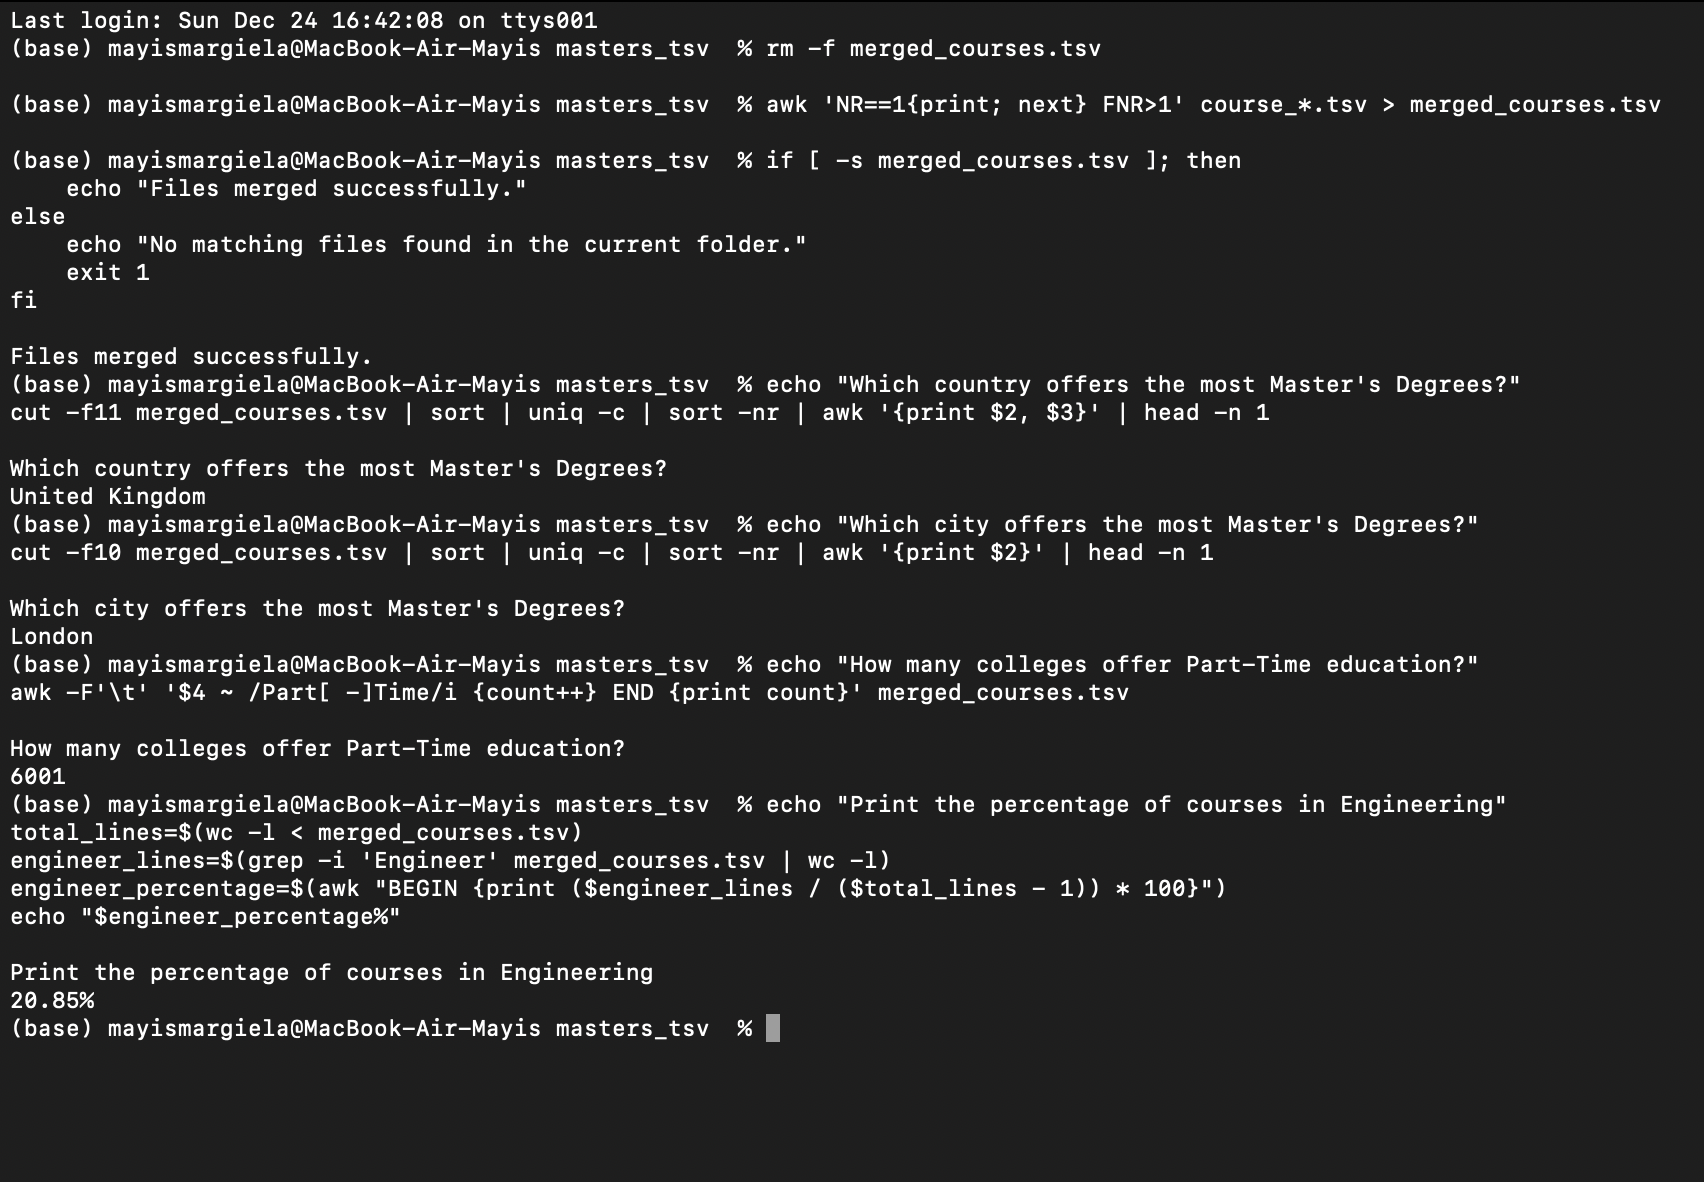

### 7. Algorithmic Question (AQ)

In [2]:
d, sumHours = map(int, input().split())
minHours = []
maxHours = []

for i in range(d):
    min_i, max_i = map(int, input().split())
    minHours.append(min_i)
    maxHours.append(max_i)

remHours = sumHours - sum(minHours)

if sum(minHours) > sumHours:
    print("NO")
else:
    i = 0
    while remHours > 0:
        if minHours[i] < maxHours[i]:
            minHours[i] += 1
            remHours -= 1 
        else:
            i += 1

    print("YES")
    print(*minHours)

 2 5
 0 1
 3 5


YES
1 4


### 7.2 What is the time complexity (the Big O notation) of your solution? Please provide a detailed explanation of how you calculated the time complexity.

The time complexity of this solution is O(d), because all operations runtime depends on the total number of days.
* Reading inputs takes O(d)
* Summing the lists takes O(d)
* While loop runs d iterations, so it also takes O(d)
So if we sum time complexity of all steps we will get time complexity of O(d)

#### 7.3 Ask ChatGPT or any other LLM chatbot tool to check your code's time complexity (the Big O notation). Compare your answer to theirs. Do you believe this is correct? If the two differ, which one is right? (why?)

The time complexity of the provided algorithm depends on the values of the input variables `d` (number of days) and the relationship between the `minHours` and `maxHours` arrays. Let's analyze the key components:

1. **Input Reading:**
   - Reading `d` and `sumHours` takes constant time, O(1).
   - Reading `min_i` and `max_i` in the loop takes O(d) time.

2. **Summing Arrays:**
   - Computing the sum of `minHours` and `maxHours` takes O(d) time each.

3. **Adjustment Loop:**
   - The `while` loop iterates at most `d` times, as it goes through each day. In the worst case, each day's hours need to be adjusted to reach the desired sum.
   - Within the loop, each iteration involves constant-time operations (comparisons, additions, and subtractions).

So, the overall time complexity can be expressed as O(d) + O(d) + O(d) = O(d). The dominant factor in this algorithm is the number of days `d`.

In summary, the time complexity of this algorithm is linear with respect to the number of days (`d`).

ChatGPT gave the right answer for this question.

#### What do you think of the optimality of your code? Do you believe it is optimal? Can you improve? Please elaborate on your response.

I think my code is optimal, because time complexity for my solution is O(d) and there is no possible way to reduce it, since we need to run each day atleast once
The space complexity is also optimal, because we need to store data for each day, and there is no possible way to improve this solution.